In [125]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

## EDA: Climate Data

In [126]:
# Read in CSVs downloaded and pre-filtered from NOAA
temps_05_23 = pd.read_csv("alameda_county_temps_2005_2023.csv")
temps_90_04 = pd.read_csv("alameda_county_temps_1990_2004.csv")
temps_81_89 = pd.read_csv("alameda_county_temps_1981_1989.csv")

# Concatenate all data, drop unneeded columns, and drop rows with all null values
temps_81_23 = pd.concat([temps_81_89,temps_90_04,temps_05_23],ignore_index=True).sort_values('DATE')
temps = temps_81_23.drop(['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION','TAVG'],axis=1)
temps.dropna(thresh=3,inplace=True)

# Aggregate temperatures s by day
daily_temps = temps.groupby(by='DATE').mean().reset_index()
daily_temps['DATE'] = pd.to_datetime(daily_temps['DATE'])


### Defining heatwaves
From [EPA](https://www.epa.gov/climate-indicators/climate-change-indicators-heat-waves): ...a period of two or more consecutive days when the daily minimum apparent temperature (the actual temperature adjusted for humidity) in a particular city exceeds the 85th percentile of historical July and August temperatures (1981–2010) for that city.

In [127]:
# define historical range 
historical_range = daily_temps.loc[(daily_temps['DATE']>='1981-01-01') & (daily_temps['DATE'] <= '2010-12-31')]
july = historical_range[historical_range['DATE'].dt.month==7]
august = historical_range[historical_range['DATE'].dt.month==8]
july_august = pd.concat([july,august])

# set heatwave threshold according to EPA definition 
heatwave_threshold = july_august['TOBS'].quantile(0.85)

# read in humidity data from NOAA
humidity = pd.read_csv("humidity.csv").drop(['STATION','REPORT_TYPE','SOURCE'],axis=1).dropna() #in alameda county

# clean and aggregate humidity data to match temperature data
avg_humidity = humidity.groupby('DATE').mean().reset_index()
avg_humidity['DATE'] = pd.to_datetime(avg_humidity['DATE'])
avg_humidity['DATE'] = avg_humidity['DATE'].dt.strftime('%Y-%m-%d')
avg_humidity['DATE'] = pd.to_datetime(avg_humidity['DATE'])
avg_humidity = avg_humidity.set_index('DATE')


Heat index calculation from [NOAA](https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml) to determine apparent temperature

In [128]:
def heat_index(T, RH): 
    hi =  0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
    if hi >= 80:
        hi = -42.379 + 2.04901523*T + 10.14333127*RH - \
        .22475541*T*RH -.00683783*T*T - .05481717*RH*RH + \
        .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
        if RH < 13 and T > 80 and T < 112:
            hi = hi - ((13-RH)/4)*np.sqrt((17-np.abs(T-95.))/17)
        if RH > 85 and T > 80 and T < 87:
            hi = hi + ((RH-85)/10) * ((87-T)/5)
    return hi

In [129]:
# Add heat index and overheated columns
daily = daily_temps.loc[(daily_temps['DATE']>='2006-01-01')&(daily_temps['DATE']<='2023-11-30')].copy().reset_index().drop('index',axis=1) #to match available humidity data
daily = daily.join(avg_humidity,on='DATE').rename(columns={'DailyAverageRelativeHumidity':'humidity'})
daily['heat_index'] = daily.apply(lambda x:heat_index(x['TOBS'],x['humidity']), axis=1) #using average temp instead of min
daily['is_overheated'] = daily['heat_index']>heatwave_threshold

# Add whether day is part of a heatwave
daily['is_heatwave'] = [False for i in range(daily.shape[0])]
d=daily.copy(deep=True)
for i in np.arange(1,d.shape[0]-2):
    if (d.iloc[i]['is_overheated']==True and d.iloc[i+1]['is_overheated']==True) \
    or (d.iloc[i]['is_overheated']==True and d.iloc[i-1]['is_overheated']):
        d.loc[i,'is_heatwave'] = True

In [130]:
# classify day according to heat index 
def heat_index_classification(heat_index):
    if heat_index >= 80 and heat_index <= 90:
        return 'Caution'
    elif heat_index >= 90 and heat_index <= 103:
        return 'Extreme Caution'
    elif heat_index >= 103 and heat_index <= 124:
        return 'Danger'
    elif heat_index >= 125:
        return 'Extreme Danger'
    else: 
        return 'None'

In [131]:
# add heat index classification row
d['heat_index_classification'] = d.apply(lambda row: heat_index_classification(row['heat_index']),axis=1)

# rename columns for readability
d.rename(columns={'DATE':'date','TMAX':'tmax','TMIN':'tmin','TOBS':'avg_temp'},inplace=True)


The results of this EDA were then stored in heat.csv for ease of access.

## EDA: Energy Data

In [134]:
import requests
import json

In [135]:
# request data from EIA API
url = "https://api.eia.gov/v2/electricity/rto/daily-region-sub-ba-data/data/?frequency=daily&data[0]=value&facets[subba][]=PGAE&facets[timezone][]=Pacific&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"
params = {'api_key':'vgyKsY7pYEHEeo0dncg7ho5nlLp0h2JjAAMBT6nL'}

# specify filters and granularity
header = {
    "frequency": "daily",
    "data": [
        "value"
    ],
    "facets": {
        "subba": [
            "PGAE"
        ],
        "timezone": [
            "Pacific"
        ]
    },
    "start": "2019-01-01",
    "end": "2023-12-31",
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}

r = requests.get(url,params=params,headers={"X-Params":json.dumps(header)})
demand = pd.DataFrame(r.json()['response']['data']).drop(['subba','parent','subba-name','parent-name','timezone'],axis=1)
demand['value'] = pd.to_numeric(demand['value'])

Results of this EDA were stored in energy_demand.csv.

## EDA: Putting heat and demand together

In [138]:
# read in respective data
heat = pd.read_csv('heat.csv')
energy_demand = pd.read_csv('energy_demand.csv')

# combine dataframes
hed = pd.merge(heat, energy_demand,left_on='date',right_on='period')\
        .drop(['period','value-units'],axis=1).rename(columns={'value':'demand'}).set_index('date')

# define threshold for "impacted" energy demand
impacted_thresh = hed['demand'].quantile(0.9)
hed['is_impacted'] = hed['demand']>=impacted_thresh

# add a column to indicate whether the next day is impacted
hed['tmrw_impacted'] = hed['is_impacted'].shift(1)

# minimal null values, so drop those rows
hed.dropna(inplace=True)

# standardize heat index and demand
scaler = StandardScaler()
hed['z_heat_index'] = scaler.fit_transform(np.asarray(hed['heat_index']).reshape(-1,1))
hed['z_demand'] = scaler.fit_transform(np.asarray(hed['demand']).reshape(-1,1))

## Visualizations
Plot heat index over 2019

In [144]:
heat['date'] = pd.to_datetime(heat['date'])
heat_2019 = heat[heat['date'].dt.year==2019]

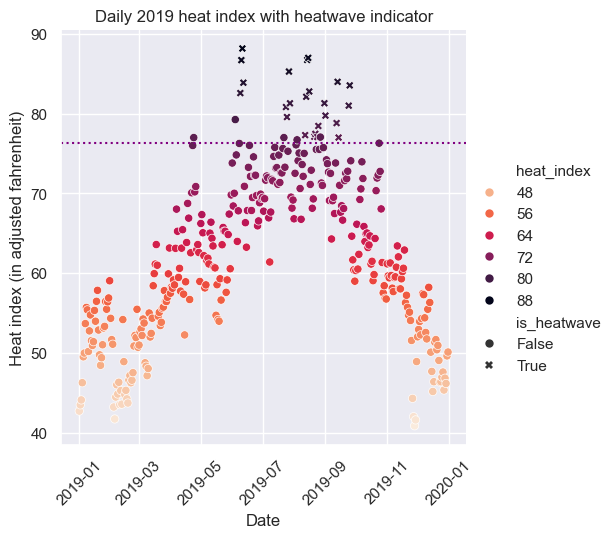

In [145]:
sns.set_theme()
hp_2019 = sns.relplot(data=heat_2019, x='date',y='heat_index', hue='heat_index',\
                      style='is_heatwave', palette='rocket_r')\
                        .set(title='Daily 2019 heat index with heatwave indicator')
plt.axhline(y=heatwave_threshold,color='purple',linestyle=':')
hp_2019.set_axis_labels('Date','Heat index (in adjusted fahrenheit)')
hp_2019.set_xticklabels(rotation=45);

Plot energy demand over 2019

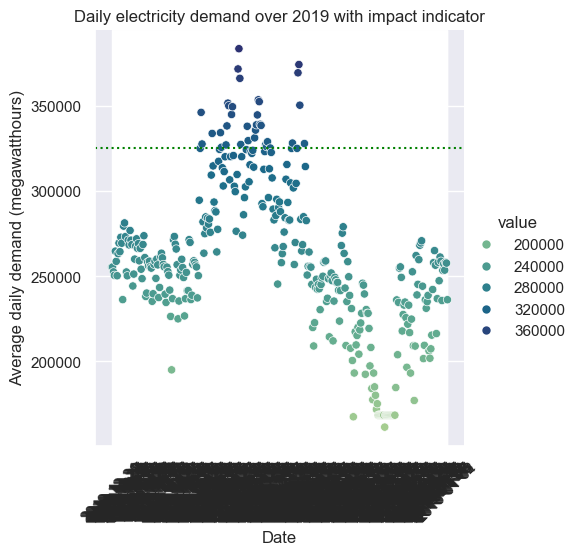

In [147]:
energy_demand['date'] = pd.to_datetime(energy_demand['period'])
impact_thresh = energy_demand['value'].quantile(0.9)
demand_2019 = energy_demand[energy_demand['date'].dt.year == 2019]

d_2019 = sns.relplot(data=demand_2019, x='period',y='value',hue='value',palette='crest')\
            .set(title='Daily electricity demand over 2019 with impact indicator')
plt.axhline(y=impact_thresh, color='green',linestyle=':')
d_2019.set_axis_labels('Date','Average daily demand (megawatthours)')
months = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']
d_2019.set_xticklabels(rotation=45);

Plot heat index and energy demand together

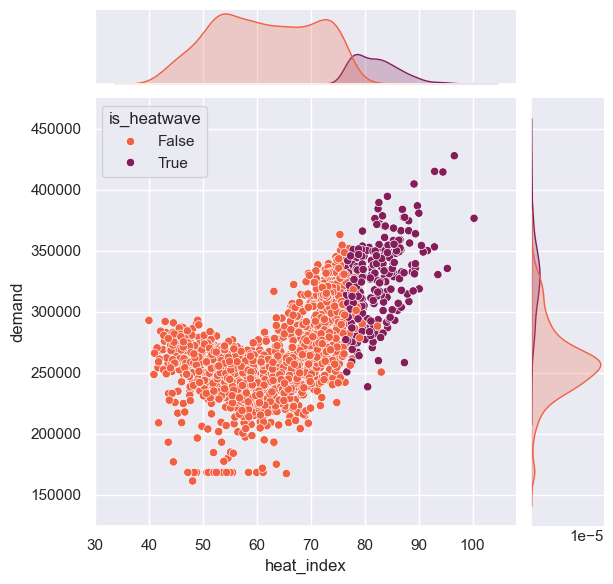

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.jointplot(data=hed,x='heat_index',y='demand',hue='is_heatwave', palette='rocket_r')
plt.show();

## Modeling

In [149]:
X_features = ['tmax','tmin','avg_temp','humidity','heat_index','is_heatwave']
#y_features = ['demand','is_impacted']
X = hed[X_features]
y = hed['is_impacted']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [150]:
# Logistic regression (GLM)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

       False       0.93      0.98      0.96       318
        True       0.75      0.44      0.55        41

    accuracy                           0.92       359
   macro avg       0.84      0.71      0.75       359
weighted avg       0.91      0.92      0.91       359



In [151]:
# KNN model (non-parametric)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test,y_pred_knn))


              precision    recall  f1-score   support

       False       0.94      0.97      0.96       318
        True       0.72      0.56      0.63        41

    accuracy                           0.92       359
   macro avg       0.83      0.77      0.79       359
weighted avg       0.92      0.92      0.92       359



/Users/areeyatipyasothi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [152]:
# decision tree classifier (non-parametric)
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42, min_samples_leaf=50)
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)

print(classification_report(y_test,y_pred_dtc))

              precision    recall  f1-score   support

       False       0.92      0.98      0.95       318
        True       0.75      0.37      0.49        41

    accuracy                           0.91       359
   macro avg       0.84      0.68      0.72       359
weighted avg       0.90      0.91      0.90       359



Text(0.5, 1.0, 'ROC Curves')

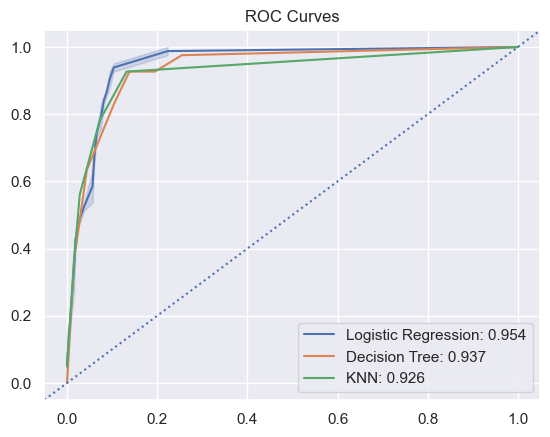

In [153]:
# compare classifiers 
from sklearn.metrics import roc_curve, auc

prob_lr = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, t = roc_curve(y_test, prob_lr)

prob_dtc = dtc.predict_proba(X_test)[:,1]
fpr_dtc, tpr_dtc, t = roc_curve(y_test,prob_dtc)

prob_knn = knn.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, t = roc_curve(y_test,prob_knn)

lr_auc = 'Logistic Regression: ' + str(round(auc(fpr_lr, tpr_lr),3)) 
dtc_auc = 'Decision Tree: ' + str(round(auc(fpr_dtc,tpr_dtc),3))
knn_auc = 'KNN: ' + str(round(auc(fpr_knn,tpr_knn),3))

sns.lineplot(x=fpr_lr,y=tpr_lr, label = lr_auc)
sns.lineplot(x=fpr_dtc,y=tpr_dtc, label=dtc_auc)
sns.lineplot(x=fpr_knn,y=tpr_knn,label=knn_auc)
plt.axline((0,0),slope=1,linestyle=':')
plt.title('ROC Curves')

### (Bonus) Implement gamma model with log link to predict demand

In [154]:
X_features = ['tmax','tmin','avg_temp','humidity','heat_index']
X = hed[X_features]
y = hed['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

gamma = sm.GLM(y_train, X_train, family=sm.families.Gamma(link=sm.families.links.log()))
gamma_fit = gamma.fit()

print(gamma_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 demand   No. Observations:                 1434
Model:                            GLM   Df Residuals:                     1429
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                         0.26380
Method:                          IRLS   Log-Likelihood:                -18843.
Date:                Wed, 18 Dec 2024   Deviance:                       281.28
Time:                        04:03:14   Pearson chi2:                     377.
No. Iterations:                   100   Pseudo R-squ. (CS):            -0.9576
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmax           0.0220      0.006      3.768      0.0